# Lab 3:  Bayesian Estimation in Hierarchical Graphical Models
Welcome to the third Data 102 lab! 

The goal of this lab is to go over Bayesian Estimation and provide an introduction to Hierarchial Graphical Models.

The code and responses you need to write are commented out with a message **"TODO: fill ..."**. There is additional documentation for each part as you go along.


## Collaboration Policy
Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

## Gradescope Submission
To submit this assignment, rerun the notebook from scratch (by selecting Kernel > Restart & Run all), and then print as a pdf (File > download as > pdf) and submit it to Gradescope.


**We encourage you to finish this assignment by Thursday, Feb. 11.**

**For full credit, this assignment should be completed and submitted before Sunday, Feb 14, 2021 at 11:59 PM. PST**

## Collaborators
Write the names of your collaborators in this cell.

`<Collaborator Name> <Collaborator e-mail>`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import beta, binom
import itertools
from ipywidgets import interact, interactive

import hashlib
%matplotlib inline

sns.set(style="dark")
plt.style.use("ggplot")

def get_hash(num, significance = 4):
    num = round(num, significance)
    """Helper function for assessing correctness"""
    return hashlib.md5(str(num).encode()).hexdigest()

## Question 0: Review

### 0a) The Bayesian posterior risk is a function of the data. True or False?

In [2]:
ans0a = True # TODO: fill in either True or False as a boolean.

In [3]:
assert(get_hash(ans0a) == 'c4ca4238a0b923820dcc509a6f75849b')
print("Passed!")

Passed!


### 0b)

Suppose in a 1-dimensional linear regression, you have as your model $y = bx + \epsilon$ with $\epsilon \sim N(0, \sigma^2)$, a scalar regression weight $b \sim N(0, \sigma_{b}^2)$, and scalar data point $x$.  What is the distribution of $y$ given $b$ and $x$? In other words, $y|b, x \sim$ \___\___\_____?

Note: Fill in the blank with both the distribution and the corresponding parameters.

$y|b, x \sim N(bx, \sigma^2)$

`TODO: fill in with your answer.`

### 0c) Risk can be understood as the expected loss. True or False?

In [4]:
ans0c = True # TODO: fill in either True or False as a boolean.

In [5]:
assert(get_hash(ans0c+1) == 'c81e728d9d4c2f636f067f89cc14862c')
print("Passed!")

Passed!


## Question 1: Beta-Binomial Graphical Model

In this question we will look at the COVID modeling example from one of the optional lecture videos. Here's the summary of what you need to know:

In this problem we are trying to estimate the COVID infection risk in households. To do that we curate a list of K studies. Each study has an associated pair $(N_i, X_i)$ where $N_i$ denotes the number of susceptible individuals considered and $X_i$ is the number of them that became infected. In our modeling assumptions we assume that each susceptible person gets infected with probability $\theta_i$. In epidemiology, this quantity is known as Secondary Attack Rate, or SAR for short.

We're trying to do two things: 
1. We want to *combine* the information from all the studies, so we can get a better estimate of SAR than we would with any individual study on its own. 
2. We want to understand why the studies got different results: Specifically, we'd like to figure out the regions with the *lowest* SAR, so that we can investigate what contributed to their relative success. In the other direction, we want to know which regions had the *highest* SAR, since they're likely the ones most urgently in need of intervention measures to help slow the spread.

For more information, you can always watch the [video from the lecture 7 playlist](https://www.youtube.com/watch?v=Gq9AhZYk8wk&list=PLSEfoRJ1f3UOcSxA5ORZ3RRRiGiQ0DAS5&index=7).

In [6]:
# Read out a dataset 
study_df = pd.read_csv("study_df.csv", header=0)
study_df

,Name,X,N
0,Study 0,3,8
1,Study 1,2,11
2,Study 2,6,12
3,Study 3,9,27
4,Study 4,11,38
5,Study 5,21,59
6,Study 6,27,79
7,Study 7,23,82
8,Study 8,26,120
9,Study 9,57,145


### 1.a Compute the trivial estimate of SAR


The most straingforward way to estimate the probability of infection (SAR) is to divide the number of infected cases by the number of susceptible cases. 

Compute this quantity in the cell below.

In [7]:
# TODO: Complete the function
def trivial_theta_estimate(N_value, X_value):
    """
    Computes the trivial estimate of the Secondary Attack Rate
    
    Inputs:
        N_value : int, number of susceptible individuals
        X_value : int, number of infected individuals
        
    Output:
        theta_est : float, estimate of probability of infection (SAR)
    """
    theta_est = X_value/N_value # TODO: fill in
    return theta_est

In [8]:
# Validation tests
n_test_array = [10, 100, 1000]
x_test_array = [10, 34, 852]
res_array = [trivial_theta_estimate(n, x_test_array[i]) for i,n in enumerate(n_test_array)]
hash_list=['e4c2e8edac362acab7123654b9e73432','149dd5056939405870c9bb50cbc8691c','83659da620f470d5a131b5a9c76cfee7']
for i,res in enumerate(res_array):
    assert get_hash(res) == hash_list[i]
print('Test passed!')

Test passed!


In [9]:
# Apply  'trivial_theta_estimate' to each row of the dataframe and add a new column to hold the result
study_df['Trivial estimate'] = study_df.apply(lambda row: trivial_theta_estimate(row['N'], row['X']), axis =1)
study_df.sort_values('Trivial estimate')

,Name,X,N,Trivial estimate
1,Study 1,2,11,0.181818
8,Study 8,26,120,0.216667
7,Study 7,23,82,0.280488
4,Study 4,11,38,0.289474
3,Study 3,9,27,0.333333
6,Study 6,27,79,0.341772
5,Study 5,21,59,0.355932
11,Study 11,122,341,0.357771
0,Study 0,3,8,0.375000
9,Study 9,57,145,0.393103


**Trivial estimates suggest that both minimum and maximum probabilities of infection correspond to small studies.**

|      | Max     | Min     |
|------|---------|---------|
| Name | Study 1 | Study 2 |
| X    | 2       | 8       | 
| N    | 11      | 12      |
|$\theta$| 0.18  | 0.50    |


Intuitively, we probably shouldn't be making policy decision based on such small studies alone, especially when this dataset has other studies with tens or even hundreds of people. We would like to balance between strong evidence from the small studies and high confidence in estimates from larger studies.

Bayesian inference provides a flexible framework to balance our apriori beliefs with new evidence. Consider the following graphical model:


![](GM1.png)


Note that this graphical model looks a little different from the one you saw in the lecture videos. Just like what you've already seen, the circles represent random variables, and shaded circles represent observed random variables. The diamond at the top represents fixed, unknown parameters . You'll also see people draw dots or squares for these: there isn't really one consistent notation.

Here are a few important quantities in Bayesian inference. This lingo will be used at length in this course and in anything you'll learn in the future about Bayesian inference, so make sure you get familiar with it.  



### Joint Density / Joint Distribution:
The structure of the graphical model specified the full joint density of the parameters and data in the model. For this example the join density is:
$$p(\theta_1, \theta_2, \ldots, \theta_K, X_1, \ldots, X_K) = \prod_{\text{vertex $V$ in graph}}p(V|\text{parent of $V$}) = \prod_{i=1}^K \underbrace{p(\theta_i|\alpha, \beta)}_{\text{prior of $\theta_i$}} \prod_{i=1}^K \underbrace{p(X_i|\theta_i)}_{\text{likelihood of data $X_i$}}$$

The factorization of the joint density into products of priors and likelihoods is the key feature of Hierarchical Models. It allows to take a complex $2K$-dimensional joint probability and factorize it into products of 1-dimensional probabilities. This factorization is useful because it lets us simplify the distribution and control the amount of computation we have to do.



### Prior:  $\theta_i \sim Beta(\alpha, \beta)$

We have the prior distribution:

$$
\begin{align}
p(\theta_i) 
    &= \theta_i^{\alpha-1}(1-\theta_i)^{\beta-1} \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)+\Gamma(\beta)} \\
    &\propto_{\theta_i}\theta_i^{\alpha-1}(1-\theta_i)^{\beta-1}
\end{align}
$$ 

where $\Gamma$ is the [gamma function](https://en.wikipedia.org/wiki/Gamma_function). Since $\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)+\Gamma(\beta)}$ does not depend on the value of $\theta$. It is a scaling factor that ensures that $p(\theta_i)$ is a valid probability function. This leads to a common notation in practice: $p(\theta_i)\propto_{\theta_i}\theta_i^{\alpha-1}(1-\theta_i)^{\beta-1}$. The symbol $\propto_{\theta_i}$ means _proportional in $\theta_i$_. This is a little more explicit than the $\propto$ notation that you usually see.



### Likelihood: $X_i|\theta \sim Binomial(N_i, \theta_i)$

We'll use the notation $p(X_i|\theta)$ for the likelihood function, which represents our belief about the distribution of the data if we know what the parameter $\theta$ is (in other words, if we condition on $\theta$).
$$p(X_i|\theta_i) = \binom{N_i}{X_i} \theta_i^{X_i}(1-\theta_i)^{N_i - X_i}$$

### Marginal: Unconditional distribution of $X_i$:

$$
\begin{align}
p(X_i)
    &= \int_{\theta_i} \overbrace{p(X_i, \theta_i)}^{\text{joint distribution}} \\
    &= \int_0^1 \underbrace{p(X_i|\theta_i)}_{\text{likelihood}} \,\underbrace{p(\theta_i)}_{\text{prior}} \,d\theta_i
\end{align}
$$

This is the marginal distribution over the data: we can plug in a particular set of $X_i$ values and get out the probability that our model assigns to those values, averaged over all possible values of $\theta$.

When formulating a model, we usually choose the prior and the likelihood based on what we know about the problem. This means that computing this marginal distribution over $X_i$ requires *marginalizing* over the parameter $\theta$: that involves either a summation or an integral (in this case it's an integral because $\theta$ is continuous).

### Posterior: $\theta_i|X_i$
The goal of many estimation problems is to obtain the posterior distribution of the parameter of interest $\theta_i$ conditioned on the data $X_i$.
\begin{align}
p(\theta_i|X_i) &= \frac{p(X_i|\theta_i)p(\theta_i)}{p(X_i)} \quad \text{(by Bayes Rule)}\\
&\propto_{\theta} p(X_i|\theta_i)p(\theta_i) \quad \text{(the data marginal $p(X_i)$ does not depend on $\theta$)}\\
&\propto_{\theta}  \underbrace{\theta_i^{X_i}(1-\theta_i)^{N_i - X_i}}_{\text{likelihood}} \underbrace{\theta^{\alpha-1}(1-\theta)^{\beta-1}}_{\text{prior}}\\
&\propto_{\theta}\theta_i^{\alpha + X_i - 1}(1-\theta_i)^{\beta + N_i - X_i - 1} \quad \text{unnormalized Beta density}\\
\end{align}



### Hence $\theta_i|X_i \sim Beta(\alpha + X_i, \beta + N_i - X_i)$


The fact that the posterior probability comes from the same distribution family is known as *conjugacy*. It is a very useful property because it allows us to compute the posteriors in close form.

### 1.b Conceptual

1.b (i) When specifying a Bayesian model, we use our domain knowledge to establish certain distributions, and then we use computation to find other ones. Which of the following do we establish using our domain knowledge? Pick all that apply.

(a) Prior

(b) Likelihood

(c) Marginal distribution of the data

(d) Posterior 

a, b

`TODO: fill in with the relevant letters above`

### 1.c Examine the prior distribution

In [10]:
def plot_beta(alpha_value, beta_value):
    x = np.arange(0, 1.01, 0.01)
    y = beta.pdf(x, alpha_value, beta_value)
    fig = plt.figure()
    plt.plot(x, y)
    plt.xlabel(r'$\theta_i$')
    plt.ylabel(r'$p(\theta_i)$')
    plt.title(r'Beta distribution with parameters $\alpha$ and $\beta$')
    plt.ylim(0, 10)
    plt.show() 

In [11]:
interactive_plot = interactive(plot_beta, alpha_value=(1, 20, 0.5), beta_value=(1,20, 0.5))
interactive_plot

interactive(children=(FloatSlider(value=10.0, description='alpha_value', max=20.0, min=1.0, step=0.5), FloatSl…

1.c (i) Fix `alpha_value = 5`, and experiment with different values of `beta_value`. Write 1 sentence of your observations.

As we slide `beta_value` from left to right, the mode of the distribution shifts from right to left.

`TODO:` fill in

1.c (ii) Fix `beta_value = 5`, and experiment with different values of `alpha_value`. Write 1 sentence of your observations.

As we slide `alpha_value` from left to right, the mode of the distribution shifts from left to right

`TODO:` fill in

1.c (iii) Set `alpha_value = beta_value = 1`, increase their value such that `alpha_value=beta_value`. Write 1 sentence of your observations.

As `alpha_value` and `beta_value` increase together, the distribution becomes more concentrated around 0.5.

`TODO:` fill in

### 1.d Compute Posterior Mean Estimates for SAR
In Problem 2 of Discussion 3 we showed that the **posterior mean** minimizes the **Bayes Risk** for the **Squared Error Loss**.

#### In the cell below write a function that computes the posterior mean corresponding to $\theta_i|X_i$.

*Hint: If you need to look up facts about certain well-known distributions, you can always (a) go to textbooks from classes you've taken before, (b) look on Wikipedia, or (c) do a simple web search.*

In [12]:
# TODO: complete the function
def posterior_mean_estimate(N_value, X_value, alpha_value, beta_value):
    """
    Computes the posterior E[theta_i|X_i] when we consider a prior theta_i ~ Beta(alpha, beta)
    
    Inputs: 
        N_value : int, total number of susceptible individuals
        X_value : int, number of individuals that became infected
        alpha_value, beta_value : floats, parameters of the prior Beta Distribution
    """
    posterior_mean = (alpha_value + X_value)/(alpha_value + beta_value + N_value) # TODO: fill in
    return posterior_mean
    

In [13]:
# Validation tests
N_test = 100
X_test = 20
alpha_test_array = [1, 10, 100]
beta_test_array = [1, 10, 100]
inputs = list(itertools.product(alpha_test_array, beta_test_array))
hash_list = ['8ae3cf8f9366cbdea2ccf7706546ba4a','f8ddc3234c0a54e55b01384bcfb23f90','82589ee1f18a2e0b9fe9d14836983102',
             '08cf5a2033e7e21ec90b6707c24facaf','70da82175ec8a195a3d8b0fa8f69681d','ced20bed08ecfba035cbc3e06657cff2',
             'c8a7feeaced214c662a999d9bf075e8c','790abc5c38e7c740420b03c24fabb05b','54fbf38cf649866815e0fefc46a1f6c7']
for i,inp in enumerate(inputs):
    assert hash_list[i] == get_hash(posterior_mean_estimate(N_test, X_test, *inp))
print('Test passed!')

Test passed!


### 1.e Examine the posterior mean estimate

Let's assume that from domain knowledge, we think that the probability of infection (SAR) is close to $\frac{1}{3}$. We pick a prior distribution for $\theta_i$s that has mean $\frac{1}{3}$. Any distribution of the form $\theta_i \sim Beta(k, 2k)$ has this property. The value of $k$ determines the 'strength' of the prior. Low values of $k$  correspond to 'flatter' priors, while larger values of $k$ correspond to 'peakier' priors. Play with the sliders in **1.b** to convince yourself.

**Examine the plotting function below and answer the qualitative questions in the next cells.**

In [14]:
study_df

,Name,X,N,Trivial estimate
0,Study 0,3,8,0.375000
1,Study 1,2,11,0.181818
2,Study 2,6,12,0.500000
3,Study 3,9,27,0.333333
4,Study 4,11,38,0.289474
5,Study 5,21,59,0.355932
6,Study 6,27,79,0.341772
7,Study 7,23,82,0.280488
8,Study 8,26,120,0.216667
9,Study 9,57,145,0.393103


In [15]:
# Do not modify: Examine the code
def plot_thetas(k):
    
    study_df["bayesian_theta"] = study_df.apply(
        lambda row: posterior_mean_estimate(row['N'], row['X'], k, 2*k), 
        axis=1
    )
    study_df["trivial_theta"] = study_df.apply(
        lambda row: trivial_theta_estimate(row['N'], row['X']), 
        axis=1
    )
    fig = plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    graph = sns.scatterplot(
        x="trivial_theta", y="bayesian_theta", 
        data=study_df, size="N", sizes=(50, 300), alpha=.8
    )
    sns.lineplot(
        x='trivial_theta', y='trivial_theta', 
        data= study_df, ls="--", color='black', lw=1
    )
    plt.ylim(0.16, 0.52)
    graph.axhline(
        1/3, color='black', 
        label = "$\frac{1}{3}$ Prior Expectation"
    )
    plt.xlabel('Trivial Estimate')
    plt.ylabel('Posterior Mean Estimate')
    
    plt.subplot(1, 2, 2)
    x = np.arange(0,1.01,0.01)
    y = beta.pdf(x, k, 2*k)
    plt.plot(x, y)
    plt.xlabel(r'$\theta_i$')
    plt.ylabel(r'$p(\theta_i)$')
    plt.title(rf'Prior: $Beta(\alpha={k}, \beta={2*k})$')
    plt.ylim(0, 10)
    plt.show()

In [16]:
interactive_plot = interactive(plot_thetas, k=(0, 50, 2))
interactive_plot

interactive(children=(IntSlider(value=24, description='k', max=50, step=2), Output()), _dom_classes=('widget-i…

In the plot above the horizontal dashed line represents the prior mean estimate $\mathbb{E}[\theta_i] = \frac{k}{k+2k} = 1/3$. The diagonal solid line marks $x=y$. Each data-point corresponds to a study, the size of the marker denotes the number of susceptible individuals in each study. Such that larger markers correspond to larger studies.

**Answer the following questions with 1-2 sentences each.**

1.d (i) Set $k=0$, what do you notice about the data points? Increase steadily the value of $k$. What happens with the points above the solid horizontal line? What about the points below it?

`TODO:` fill in

When $k=0$ the data-points are perfectly aligned with the diagonal line, meaning that the posterior mean estimate is equal to the trivial estimate. As $k$ increases, the points are being pulled towards the $\frac{1}{3}$ horizontal line. A larger $k$ indicates a stronger (more concentrated) prior, which 'pulls' the posterior mean estimates closer to the horizontal line.

1.d (ii) As you increase $k$, which points move faster, larger or slower ones? How can you explain this?

Larger markers have more data-points, hence more evidence towards the trivial estimate. In some sense it is harder for the prior to pull the posterior estimate of those points in the direction of the prior mean.

`TODO:` fill in

1.d (iii) Imagine that we let $k\to \infty$. How do you think the two graphs above will look in the limit $k\to \infty$? 

When $k \to \infty$, the graph on the right will become a point mass at $1/3$ - meaning that the prior is infinitely strong. This would pull all the point on the left graph all the way to the horizontal dashed line.

`TODO:` fill in

1.d (iv) Fill in the blank in this sentence with either "small" or "large", and explain your answer: 

*If we're very sure that the true SAR is close to $\frac{1}{3}$, we should choose a _______ value of $k$.*

Large: if we're sure that the value is closer to $1/3$, we should pick a narrow, "peaky" prior rather than a wide one.

`TODO:` fill in

## Question 2: Computational Approximate Inference

In the previous question we looked at a Beta-Binomial Graphical model. We took advantage of the conjugacy properties of the model and were able to compute closed form solutions for the posterior mean estimates.

However, as we introduce more complexity to the model, the conjugacy property quickly breaks and we have to resort to approximate inference. In this class, we'll focus primarily on *sampling* for approximate inference: this will be the topic of the next few lectures and next week's labs. In sampling-based approaches, we don't even try to get the exact posterior: instead, we generate a bunch of samples from it, and use those to approximate the distribution.

In this question you will get a taste for probabilistic programming using `PyMC3`. Spend some time perusing the [documentation](https://docs.pymc.io/), but don't worry if it doesn't fully make sense just yet. We'll be using PyMC3 to run an algorithm called Markov Chain Monte Carlo (MCMC), which you'll learn about this week. We'll start by using the same model from Q.1, and compare the results from MCMC with the exact solutions we calculated above. Then, we'll add an extra parameter to the model and make things more complex: even though we can no longer compute our posterior in closed form, MCMC will still generate samples that we can use to estimate the $\theta_i$s.

In [17]:
# Import PyMC3, and create a dummy model so that one-time initialization
# happens while you're reading over the code in the next cell.

# Note: this and the following cells may take a while to run

# You can ignore the output of this cell.

import pymc3 as pm

with pm.Model() as model:
    dummy = pm.Beta('dummy', alpha=1, beta=1)
    pm.sample(1)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\tygar\anaconda3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Only 1 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dummy]


Sampling 4 chains for 1_000 tune and 1 draw iterations (4_000 + 4 draws total) took 23 seconds.
C:\Users\tygar\anaconda3\lib\site-packages\arviz\data\base.py:174: UserWarning: More chains (4) than draws (1). Passed array should have shape (chains, draws, *shape)
  UserWarning,
C:\Users\tygar\anaconda3\lib\site-packages\pymc3\sampling.py:641: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


In [18]:
# Do not modify: Spend some time examining the code
def approximate_inference_MCMC(
    alpha_value, beta_value, study_df = study_df
):
    """
    Creates and generates samples from a PyMC3 model of
    the posterior distribution that corresponds to the
    graphical model in Q.1, using Markov Chain Monte Carlo (MCMC)
    
    Inputs:
        alpha_value, beta_value : floats, parameters of
        the prior Beta Distribution
        study_df : DataFrame containing study data
    
    Outputs: (model, trace)
        model is a PyMC3 model object, which represents the graphical model
        trace is a PyMC3 trace object, which represents 2000 samples
            of everything from the posterior
    """
    # Defines the graphical model
    with pm.Model() as model:
        # The prior for theta is a Beta distribution with parameters
        # alpha and beta, and there's one for each study.
        theta = pm.Beta(
            'theta', alpha=alpha_value, beta=beta_value, 
            shape=len(study_df)
        )
        
        # The likelihood for X is binomial, with parameter p=theta,
        # observed counts in study_df['X'], and observed N similarly
        X = pm.Binomial(
            'X', p=theta, observed=study_df['X'], n=study_df['N']
        )
        
        # Generate samples from the posterior distribution using : run 4
        # Markov chains of sampling in parallel, generating 500 samples
        # each.
        trace = pm.sample(500, chains=4, tune=1000, target_accept=0.95)
    
    return (model, trace)

Try running the following cell. 

In [19]:
# Run approximate inference
model, trace = approximate_inference_MCMC(10, 20)

# Get posterior samples of theta
thetas = trace['theta']
thetas

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 163 seconds.


array([[0.37127894, 0.34447997, 0.43188907, ..., 0.3824098 , 0.46671289,
        0.40315654],
       [0.27031635, 0.3984445 , 0.34886543, ..., 0.38732536, 0.47144939,
        0.37991448],
       [0.47360773, 0.27411169, 0.50041405, ..., 0.37823902, 0.44187558,
        0.35795545],
       ...,
       [0.22037237, 0.28578881, 0.42414899, ..., 0.38024855, 0.41397111,
        0.32786995],
       [0.41977684, 0.30922694, 0.41921556, ..., 0.40280907, 0.43806391,
        0.35464131],
       [0.29695627, 0.2957924 , 0.35303818, ..., 0.41564557, 0.39995017,
        0.36155097]])

### 2.a Using the output of PyMC3

Generate a histogram of all 2,000 posterior samples for $\theta_2$ (the SAR for Study 2). How do the samples compare to the two different estimates you saw in Question 1?

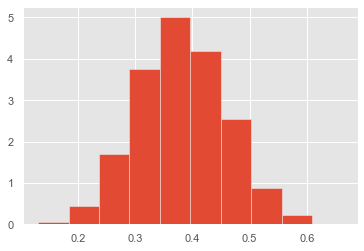

In [20]:
# TODO: fill in
plt.hist(thetas[:, 2], density=True);

The mean of the samples is close to the true posterior mean, lower than the trivial mean of $0.5$. The samples have a high variance.

`TODO:` fill in

### 2.b Compute Posterior Mean Estimates from Samples

Fill in the function that computes posterior mean estimates for $\theta_i$s for different parameters $\alpha, \beta$ of the prior distribution.

In [21]:
# TODO: complete the function
def empirical_posterior_mean_estimates(alpha_value, beta_value, study_df = study_df):
    """ 
    Computes posterior mean estimates of theta_i by performing approximate inference
    and then sampling from the posterior distribution:
    
    Inputs:
        alpha_value, beta_value : floats, parameters of the prior Beta Distribution
        study_df : DataFrame containing study data
        
    Output:
        posterior_estimates : (num_studies,) 1-D array of the same length as the 
            number of studies. posterior_estimates[i] contains the 
            mean estimate for theta_i based on running MCMC
    
    """
    model, trace = approximate_inference_MCMC(alpha_value, beta_value, study_df)
    posterior_theta_samples = trace["theta"]
    posterior_estimates = np.mean(posterior_theta_samples, axis = 0) # TODO: fill in
    return posterior_estimates

In [37]:
# Validation tests: Do not modify
posterior_estimates_test = empirical_posterior_mean_estimates(10,25)
hash_list = [["e85b79abfd76b7c13b1334d8d8c194a5"],
            ["261943f3a93b683ceeac658927f3923f"],
            ["149dd5056939405870c9bb50cbc8691c"],
            ["ba6197788db60f5e2cb45cd403fa6559"],
            ["246c0903b5a64b2a854ec1e7865f174f"],
            ["ffa243f771800363714f6055d9236fd6"],
            ["ffa243f771800363714f6055d9236fd6", "9f4721cf71c0ed18cd60356036b953cc"],
            ["45efc23f34e05a9ea4f5024988047dd6"],
            ["8f11bfb91ec29936603314c7cbc46119"],
            ["a3f2a910685f5b07f5f45a5fc1fdb389"],
            ["91afec64e32d6bf957e441df2ab638bb"],
            ["8ce3fac7e23a02ab4e00cf0f1e03310a"]]
print()

for i, est in enumerate(posterior_estimates_test):
    print("Study {}: {:.3f} ".format(i, est))
    
for i, est in enumerate(posterior_estimates_test):
    assert get_hash(est, 2) in hash_list[i]

print("Test passed!")

C:\Users\tygar\anaconda3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 175 seconds.



Study 0: 0.303 
Study 1: 0.260 
Study 2: 0.341 
Study 3: 0.305 
Study 4: 0.287 
Study 5: 0.331 
Study 6: 0.324 
Study 7: 0.281 
Study 8: 0.232 
Study 9: 0.373 
Study 10: 0.431 
Study 11: 0.352 
Test passed!


### 2.c Plot the theoretical distribution of the posterior from Question 1 and the empirical distribution of the posterior from Question 2.

Make a 4x3 plot such that each subplot corresponds to a study. 

Each subplot should contain 2 curves and a frequency histogram:
- The PDF of the prior distribution of $\theta_i$
- The PDF of the true posterior distribution $\theta_i|X_i$ computed in closed form, as in Q.1
- The histogram of posterior samples of $\theta_i|X_i$ computed in Q.2

Make sure that you properly label each curve and histogram and give each subplot a meaningful title.

To give you a mental image of what we have in mind here is a sample subplot. Don't worry if the colors in yours are different.

![](sample_graph.png)

In [26]:
# TODO: write the plotting function
def plot_densities(alpha_value, beta_value, study_df = study_df): 
    """
    Plots for each study the prior distribution, true posterior,
    and histogram of posterior samples using MCMC
    
    Inputs:
        alpha_value, beta_value : floats, parameters of the prior Beta Distribution
        study_df : DataFrame containing study data
        
    Outputs:
        fig : Figure with 12 subplots
    """
    fig, axs = plt.subplots(4, 3)
    fig.set_figheight(15)
    fig.set_figwidth(15)

    
    theta = np.arange(0, 1.01, 0.01)
    prior = beta.pdf(theta, alpha_value, beta_value)
    
    model, trace = approximate_inference_MCMC(alpha_value, beta_value, study_df)
    samples = trace['theta']
    
    for i in range(4):
        for j in range(3):
            idx = 3*i+ j
            X_i = study_df.loc[idx, 'X']
            N_i = study_df.loc[idx, 'N']
            study_name = f'Study {idx}'
            true_posterior = beta.pdf(theta, alpha_value+X_i, beta_value+N_i-X_i)
            
            ax = axs[i, j]
            ax.plot(theta, prior, label = 'Prior')
            ax.plot(theta, true_posterior, label = "Theoretical Posterior")
            ax.hist(samples[:,idx], label = "Empirical Posterior", density=True, alpha = 0.7)
            ax.set_title(study_name)
            ax.legend()
    
    plt.tight_layout()        
    plt.show()
    return fig

C:\Users\tygar\anaconda3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 140 seconds.


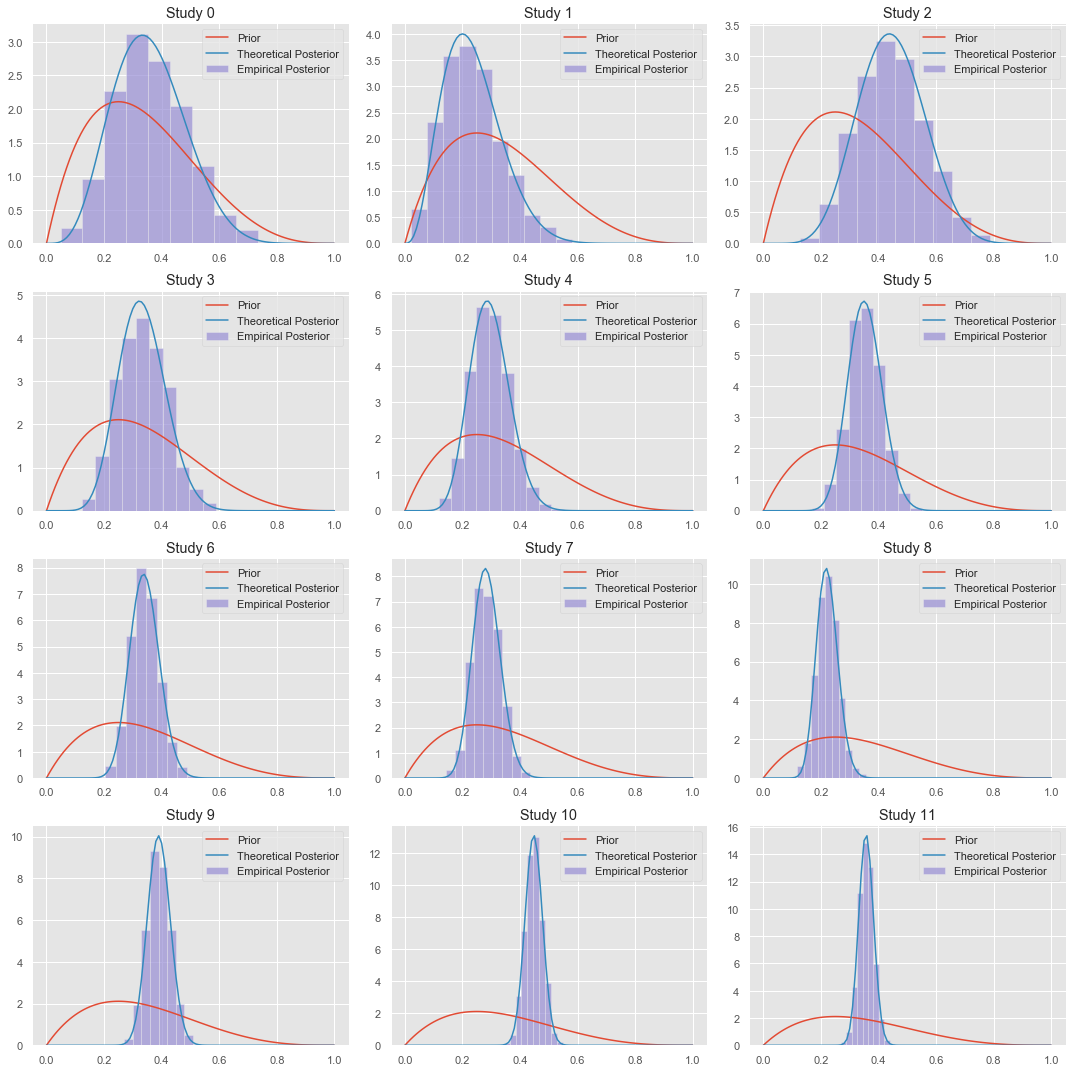

In [27]:
# Plot the resulting densities for a weak prior
fig1 = plot_densities(2, 4, study_df = study_df)

C:\Users\tygar\anaconda3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 150 seconds.


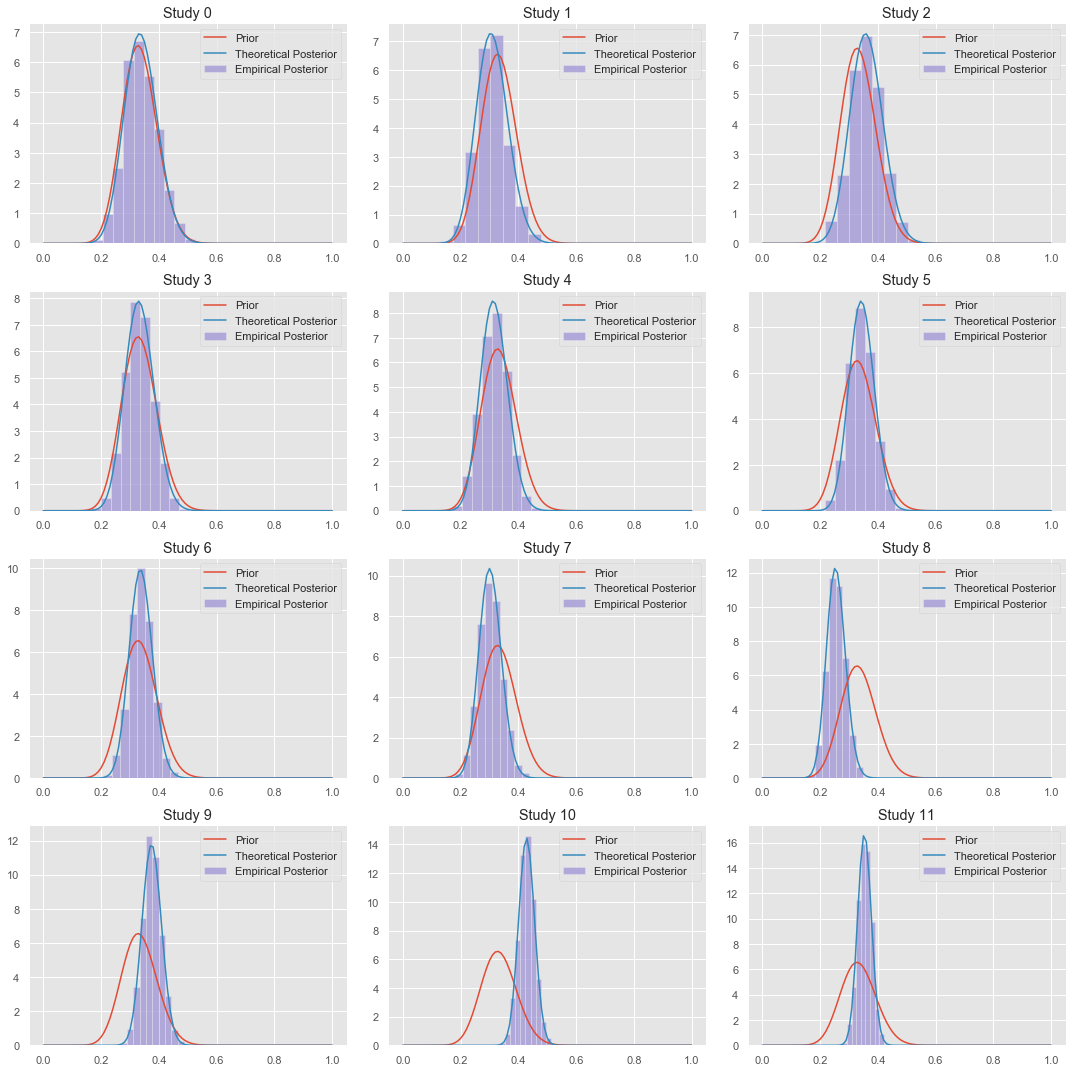

In [28]:
# Plot the resulting densities for a strong prior
fig2 = plot_densities(20, 40, study_df = study_df)

2.b (i) Compare the curve of the theoretical distribution with the histogram of samples from the empirical posterior. Are they similar or different? Explain why.

The curves of the theoretical posterior distribution fits very well with the histogram of samples forming the empirical posterior.

`TODO:` fill in

2.b (ii) Compare the two figures corresponding to 'weak' prior $\theta_i \sim Beta(2,4)$ and 'strong' prior  $\theta_i \sim Beta(20,40)$. How are they different? Explain why.

The stronger the prior is, the closer the empirical distribution (and the theoretical distribution) will be to the prior distribution. This is especially true when you look at the first few subplots of each figure, where there are fewer samples to offset the strength of the prior.

`TODO:` fill in

### 2.d Approximate Inference for a More Complex Model

The previous 2 parts served as a sanity check that the approximate inference techniques used by PyMC3 can approximate the theoretical posterior. The usefulness of such packages becomes apparent when we are dealing with more complex models that don't have conjugacy properties.

Consider the following graphical model:

![](GM2.png)

Recent studies have shown that a large fraction of COVID cases do not show symptoms, but all of the studies considered here tested only symptomatic cases. This means that the probability of testing positive (which what we observe) isn't the same as the SAR $\theta_i$! 

The estimates of the asymptomatic rate fall in the range $[0.18, 0.43]$. We assume a prior $A\sim Uniform(0.18, 0.43)$. This means that the probability that a person in a study tests positive is really $\theta_i*(1-A)$. Hence:

$$X_i|\theta_i, A \sim Binomial(N_i, \theta_i\cdot (1 - A))$$



#### Complete the `approximate_inference_asympotmatic_MCMC` function to add dependence on the asymptomatic rate:

*Hint: You may need to do a search to find the right distribution to use (instead of `pm.Binomial`, etc. above).*

In [29]:
# TODO: complete the function
def approximate_inference_asympotmatic_MCMC(alpha_value, beta_value, study_df = study_df):
    """
    Creates and fits a PyMC3 model corresponding to the graphical model above
    
    Inputs:
        alpha_value, beta_value : floats, parameters of the prior Beta Distribution
        study_df : DataFrame containing study data
    
    Outputs: (model, trace)
    """
    with pm.Model() as model:
        theta = pm.Beta('theta', alpha=alpha_value, beta=beta_value, shape=len(study_df))
        A = pm.Uniform('A', lower = 0.18, upper = 0.43)
        X = pm.Binomial('X', p=theta*(1-A), observed=study_df['X'], n=study_df['N'])
        
        trace = pm.sample(500, tune=1000, target_accept=0.95)
    return (model, trace)

Notice that the `trace` now contains samples for both `theta` and `A`!

Plot a histogram of the posterior estimates for $A$ if $\alpha=5$ and $\beta=10$. Assuming the model we defined is correct, what can you conclude about the asymptomatic rate $A$ based on the studies and the model?

In [30]:
model, trace = approximate_inference_asympotmatic_MCMC(5, 10)

C:\Users\tygar\anaconda3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, theta]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 295 seconds.


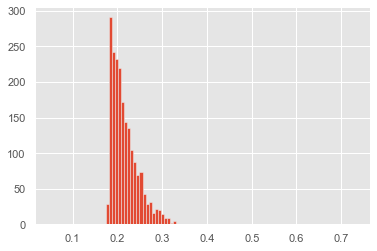

In [31]:
# TODO: fill in
plt.hist(trace['A'], bins=np.linspace(.05, .73, 100));

The asymptomatic rate is probably closer to 0.18 than 0.43.

`TODO:` fill in

In [32]:
# Validation tests: Do not modify
model_test, trace_test = approximate_inference_asympotmatic_MCMC(5, 10)
post_samples_test = trace_test['theta']
estimates = np.mean(post_samples_test, axis = 0)
rounded_estimates = np.round(estimates / 2, 2) * 2

hash_list = ['afbc48a7ca8d716f9efa7cc993316668',
             'e85b79abfd76b7c13b1334d8d8c194a5',
             '0bd1ed7e9617a4ed139b2f4014c7aa23',
             'afbc48a7ca8d716f9efa7cc993316668',
             '4a42799b212019a2db0b77644e33790c',
             '964e2b882801bd4ba988904454316d76',
             '964e2b882801bd4ba988904454316d76',
             '4a42799b212019a2db0b77644e33790c',
             '45efc23f34e05a9ea4f5024988047dd6',
             '451d13a5be2581a451c2284dcecddd4e',
             '2363c78ab7dba59b8443d958b47cfa2b',
             '0bd1ed7e9617a4ed139b2f4014c7aa23']

print()

for i, est in enumerate(estimates):
    print("Study {}: {:.3f} ".format(i, est))
    
for hash_val, est in zip(hash_list, rounded_estimates):
    assert hash_val == get_hash(est, 2)
    
print("Test passed! You are awesome!")

C:\Users\tygar\anaconda3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, theta]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 291 seconds.



Study 0: 0.374 
Study 1: 0.300 
Study 2: 0.440 
Study 3: 0.387 
Study 4: 0.360 
Study 5: 0.421 
Study 6: 0.413 
Study 7: 0.353 
Study 8: 0.285 
Study 9: 0.480 
Study 10: 0.554 
Study 11: 0.449 
Test passed! You are awesome!


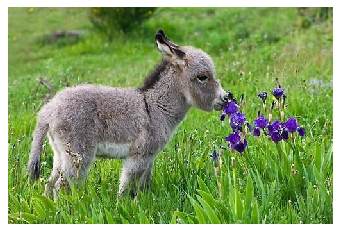

In [33]:
import matplotlib.image as mpimg
img = mpimg.imread('baby_donkey.jpg')
imgplot = plt.imshow(img)
imgplot.axes.get_xaxis().set_visible(False)
imgplot.axes.get_yaxis().set_visible(False)
plt.show()